In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    LSTM,
    Dropout,
    TimeDistributed,
    Reshape,
    GlobalMaxPool1D,
    RepeatVector,
)
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import os

plt.rcParams["figure.figsize"] = (12, 8)

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



2022-01-26 19:39:26.804924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-26 19:39:26.804940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<center><h2> Syntethic Data Generation </h2></center>

In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(
        np.linspace((np.random.rand(3)), (np.random.rand(3) + np.array([10, 15, 7])), n)
    )
    if classes[0] > 0:
        base[np.random.randint(0, n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0, n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0, n - 5)
        base[x : x + 4, 2] = 0
    if classes[3] > 0:
        x = np.random.randint(0, n - 10)
        base[x : x + 8, 1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0, n - 7)
        base[x : x + 6, 0] += 1.5
        base[x : x + 6, 2] -= 1.5
    base += np.random.rand(*base.shape) * 0.2
    return base


In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5) < 0.25
    xl.append(createRow(np.random.randint(40, 60), cl))
    yl.append(cl)



In [6]:
np.max([x.shape for x in xl]), np.min([x.shape for x in xl])

(59, 3)

[False False False False  True]


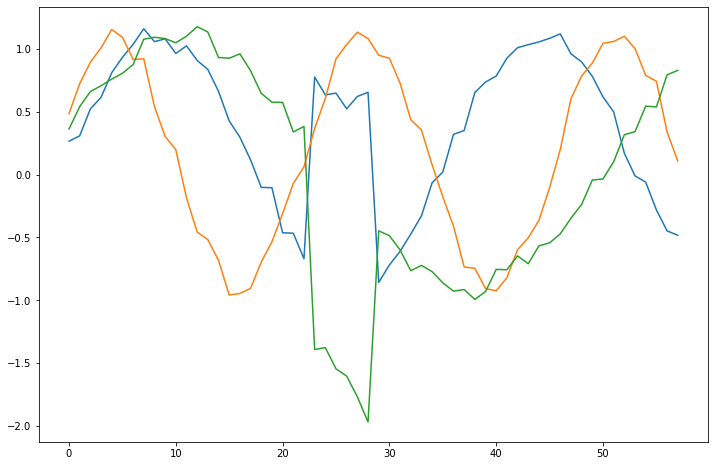

[False False False  True  True]


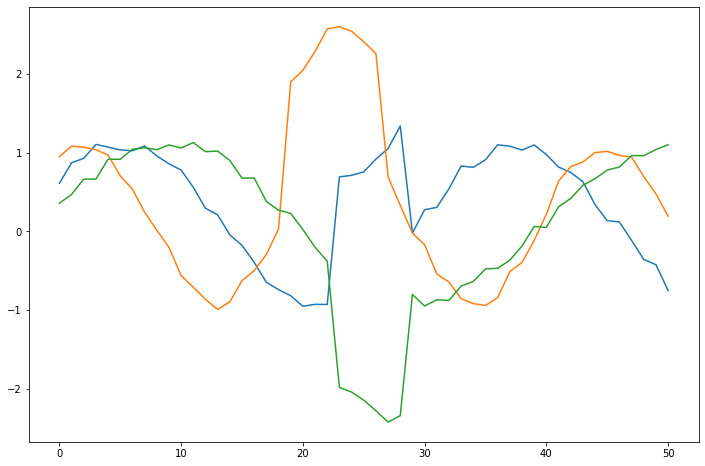

[False False False False False]


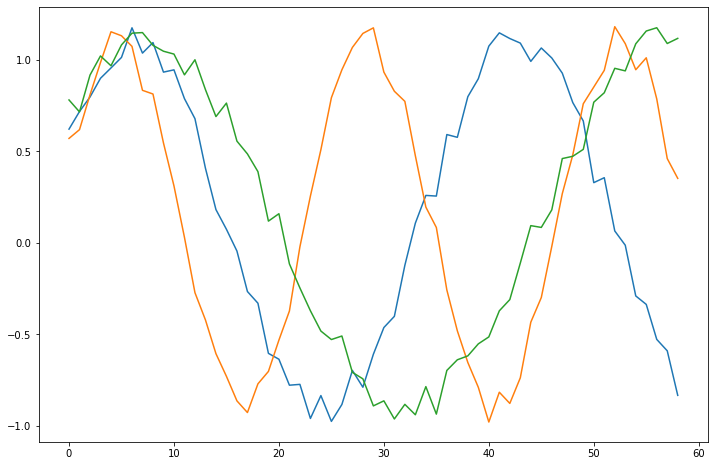

In [7]:
for i in range(3):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()


<center><h2> Preparing data for training and testing </h2></center>


In [8]:
X = np.stack(sequence.pad_sequences(xl, dtype="float64", value=0, padding="post", maxlen=60), axis=0)
Y = np.stack(yl, axis=0)

X.shape, Y.shape

((50000, 60, 3), (50000, 5))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.15, random_state=88
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42500, 60, 3), (7500, 60, 3), (42500, 5), (7500, 5))

<center><h2> Main model architecture </h2></center>


We've decided to use a simple neural network model with total of 3 LSTM layers. The first layer (input LSTM) has a size of 64 neurons. After that there is a Droput layer with 0.2 ration and RepeatVector (for creating sub-serieses). After that we've used two additional LSTM layers and a Dropout with 0.4 ratio. Two last layers are Dense one with 64 neurons and tanh as a activation function and our output layer - 5 output size and sigmoid activation.

We've tried many different approaches to layer sizes and activation functions and we've found that the best approach is to use a combination of LSTM and Dense layers below. We've also used Dropout layers with different ratios.

We also found that bigger LSTM layers are worse for our model so we keep the size of the layers to 64.
Loss function is binary crossentropy and metrics is binary accuracy as those worked best for our model.

In [10]:
model = Sequential()
model.add(LSTM(64, input_shape=(None, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(RepeatVector(X_train.shape[2]))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.4))
model.add(Dense(64, activation="tanh"))
model.add(Dense(5, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

2022-01-26 19:39:31.447838: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-26 19:39:31.447870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: fedora-desktop
2022-01-26 19:39:31.447875: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: fedora-desktop
2022-01-26 19:39:31.447993: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.46.0
2022-01-26 19:39:31.448013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.46.0
2022-01-26 19:39:31.448018: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.46.0
2022-01-26 19:39:31.448345: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU inst

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 3, 64)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [12]:
history = model.fit(
    X_train, y_train, epochs=40, batch_size=32, validation_split=0.2, verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)]
)


Epoch 1/40
1063/1063 [==============================] - 18s 14ms/step - loss: 0.4689 - binary_accuracy: 0.7938 - val_loss: 0.4539 - val_binary_accuracy: 0.7968
Epoch 2/40
1063/1063 [==============================] - 15s 14ms/step - loss: 0.3856 - binary_accuracy: 0.8313 - val_loss: 0.3645 - val_binary_accuracy: 0.8385
Epoch 3/40
1063/1063 [==============================] - 15s 14ms/step - loss: 0.3372 - binary_accuracy: 0.8540 - val_loss: 0.3280 - val_binary_accuracy: 0.8564
Epoch 4/40
1063/1063 [==============================] - 15s 14ms/step - loss: 0.3170 - binary_accuracy: 0.8634 - val_loss: 0.2917 - val_binary_accuracy: 0.8735
Epoch 5/40
1063/1063 [==============================] - 15s 14ms/step - loss: 0.2907 - binary_accuracy: 0.8752 - val_loss: 0.2858 - val_binary_accuracy: 0.8750
Epoch 6/40
1063/1063 [==============================] - 15s 14ms/step - loss: 0.2717 - binary_accuracy: 0.8815 - val_loss: 0.2427 - val_binary_accuracy: 0.8929
Epoch 7/40
1063/1063 [==================

In [13]:
INTERVAL_WIDTH = 2

explainer = Sequential()
explainer.add(Reshape((-1, INTERVAL_WIDTH, 3), input_shape=(X_train.shape[1], X_train.shape[2])))
explainer.add(TimeDistributed(model))
explainer.add(GlobalMaxPool1D())
explainer.compile("adam", loss="binary_crossentropy", metrics="binary_accuracy")
explainer.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 30, 2, 3)          0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 5)            87941     
 ibuted)                                                         
                                                                 
 global_max_pooling1d (Globa  (None, 5)                0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 87,941
Trainable params: 87,941
Non-trainable params: 0
_________________________________________________________________


In [14]:
_ = explainer.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)],
)



Epoch 1/30
665/665 [==============================] - 33s 45ms/step - loss: 0.5489 - binary_accuracy: 0.8375 - val_loss: 0.1832 - val_binary_accuracy: 0.9273
Epoch 2/30
665/665 [==============================] - 26s 38ms/step - loss: 0.1726 - binary_accuracy: 0.9313 - val_loss: 0.1473 - val_binary_accuracy: 0.9408
Epoch 3/30
665/665 [==============================] - 27s 41ms/step - loss: 0.1502 - binary_accuracy: 0.9394 - val_loss: 0.1387 - val_binary_accuracy: 0.9427
Epoch 4/30
665/665 [==============================] - 27s 40ms/step - loss: 0.1400 - binary_accuracy: 0.9425 - val_loss: 0.1295 - val_binary_accuracy: 0.9450
Epoch 5/30
665/665 [==============================] - 26s 39ms/step - loss: 0.1339 - binary_accuracy: 0.9441 - val_loss: 0.1298 - val_binary_accuracy: 0.9451
Epoch 6/30
665/665 [==============================] - 26s 39ms/step - loss: 0.1315 - binary_accuracy: 0.9449 - val_loss: 0.1277 - val_binary_accuracy: 0.9453
Epoch 7/30
665/665 [==============================] 

In [15]:
anomaly_detector = Model(inputs=explainer.layers[0].input, outputs=explainer.layers[-2].output)
anomaly_detector.compile("adam", loss="binary_crossentropy", metrics="binary_accuracy")
anomaly_detector.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_input (InputLayer)  [(None, 60, 3)]           0         
                                                                 
 reshape (Reshape)           (None, 30, 2, 3)          0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 5)            87941     
 ibuted)                                                         
                                                                 
Total params: 87,941
Trainable params: 87,941
Non-trainable params: 0
_________________________________________________________________


In [16]:
anomaly_colors = {
    0: "#edc9af",  # desert sand
    1: "#d3d3d3",  # light gray
    2: "#e6a8d7",  # light orchid
    3: "#fdfd96",  # pastel yellow
    4: "#ff9999",  # salmon pink
}
series_colors = ["#D55E00", "#009E73", "#0072B2"]  # Orange, Green, Blue

patches = []
for k in anomaly_colors.keys():
    patches.append(mpatches.Patch(color=anomaly_colors[k], label=f"Anomaly {k}"))

for ind, scl in enumerate(series_colors):
    patches.append(mpatches.Patch(color=scl, label=f"Series {ind}"))


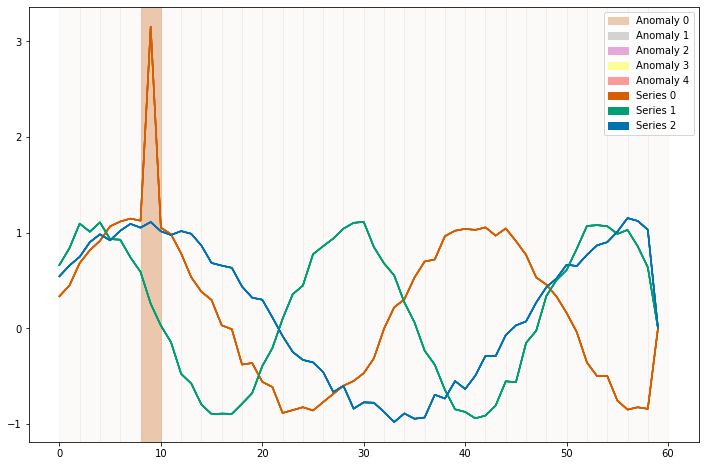

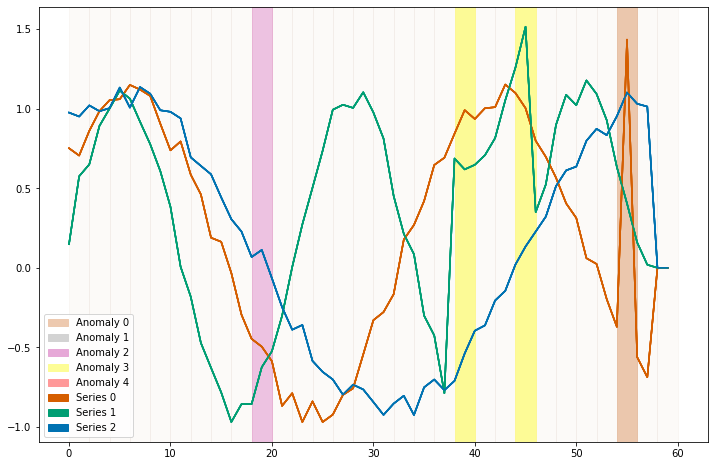

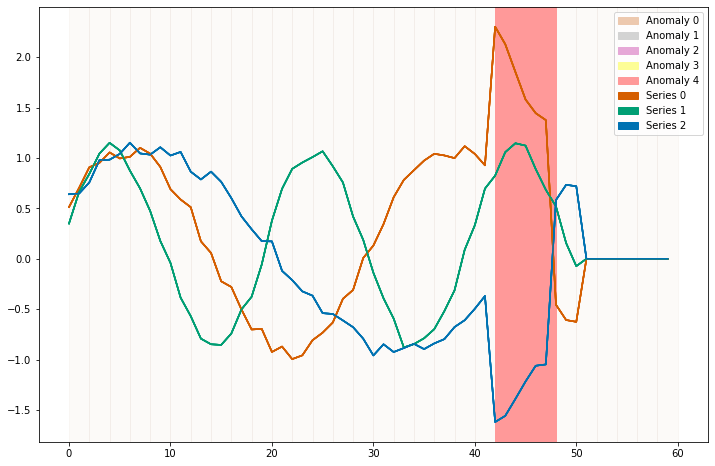

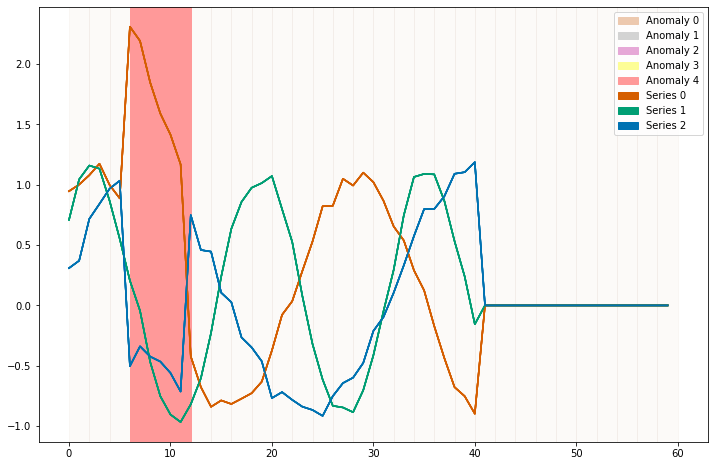

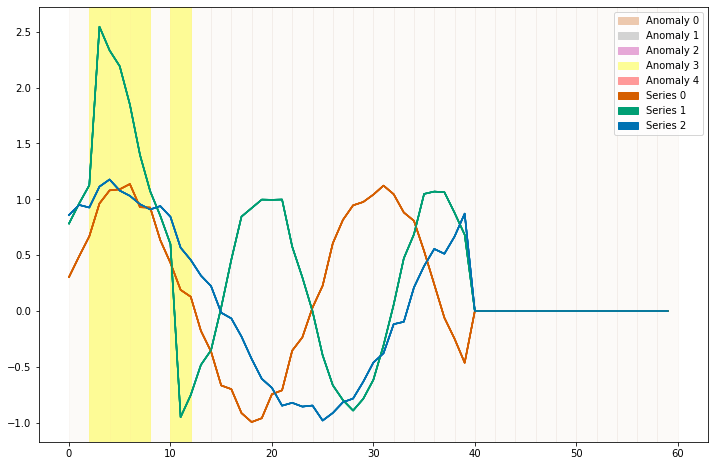

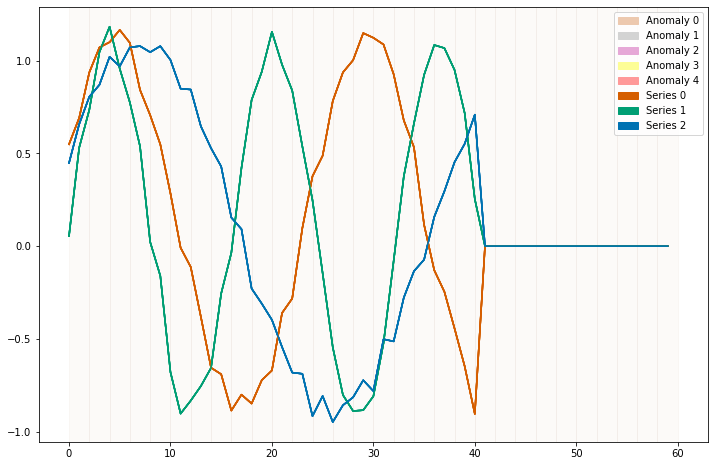

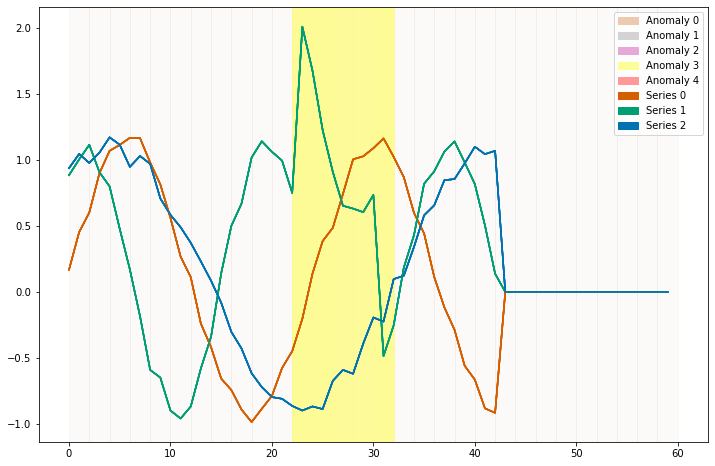

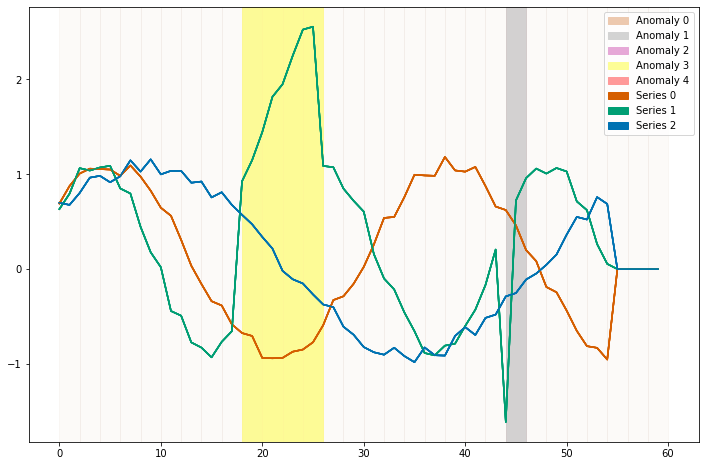

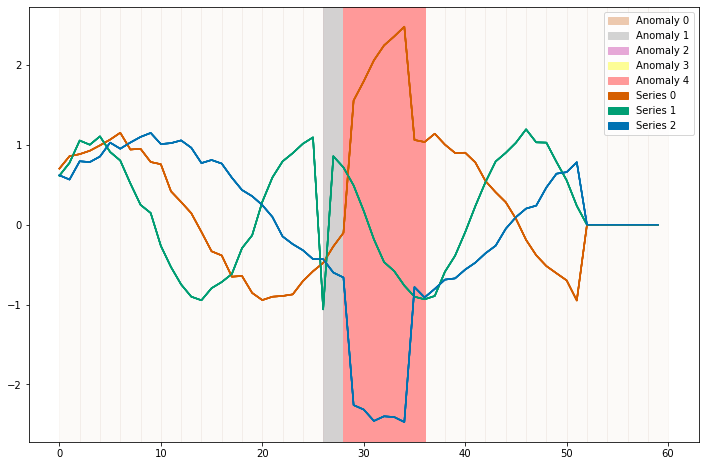

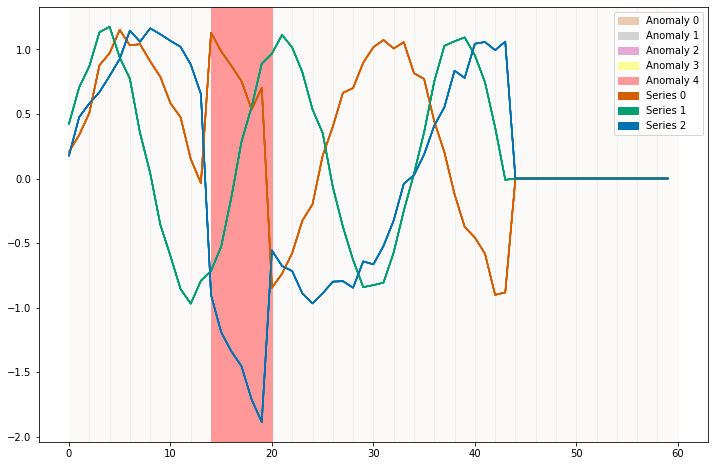

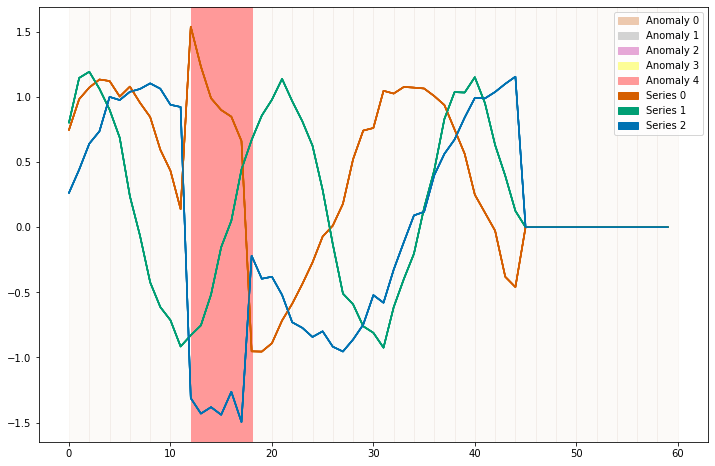

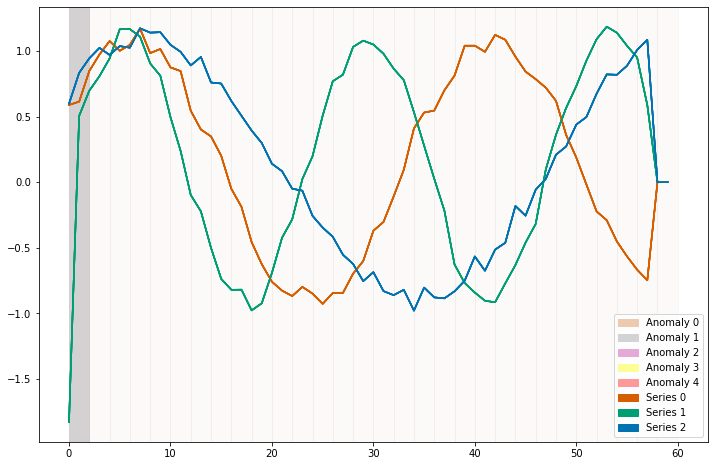

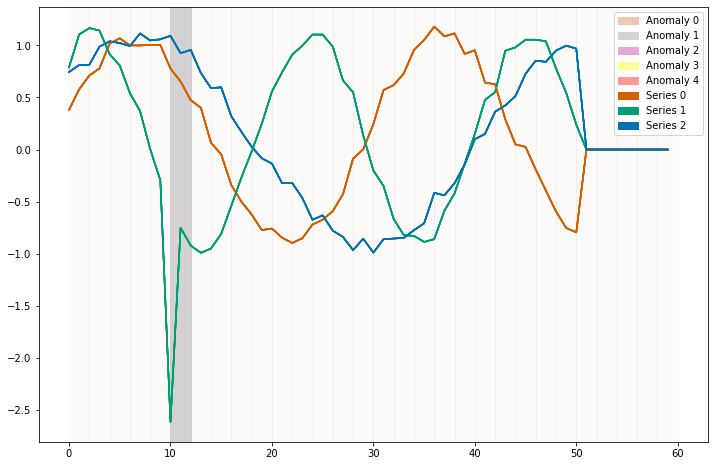

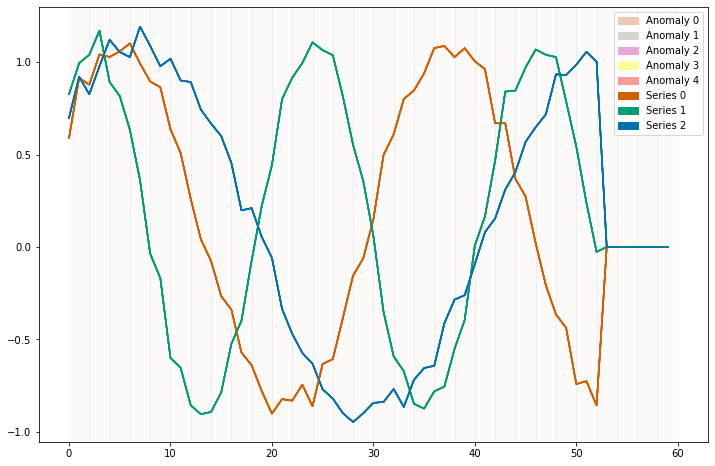

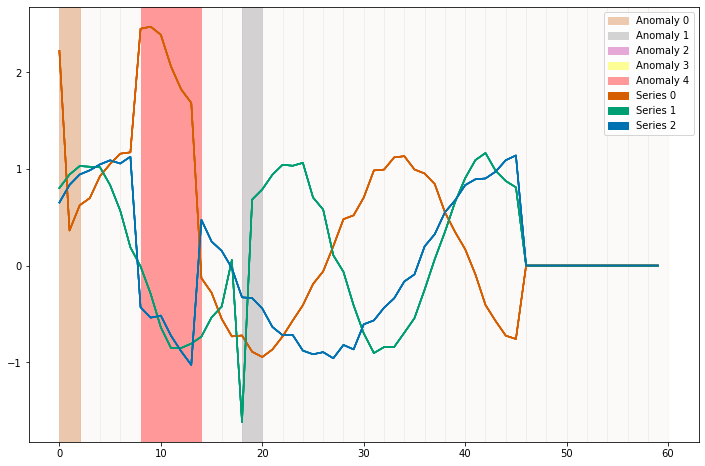

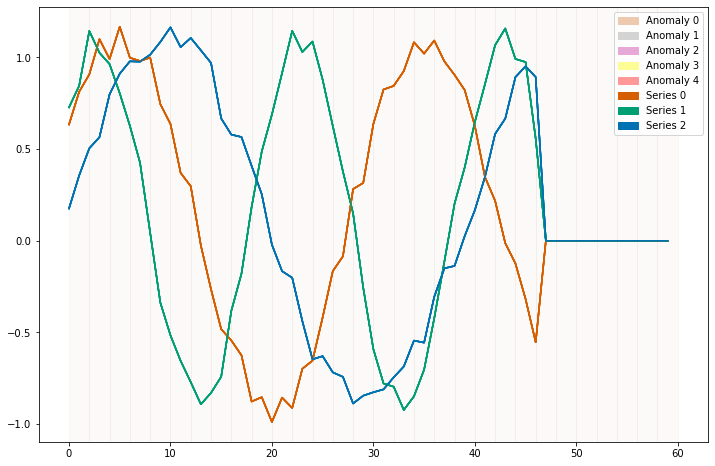

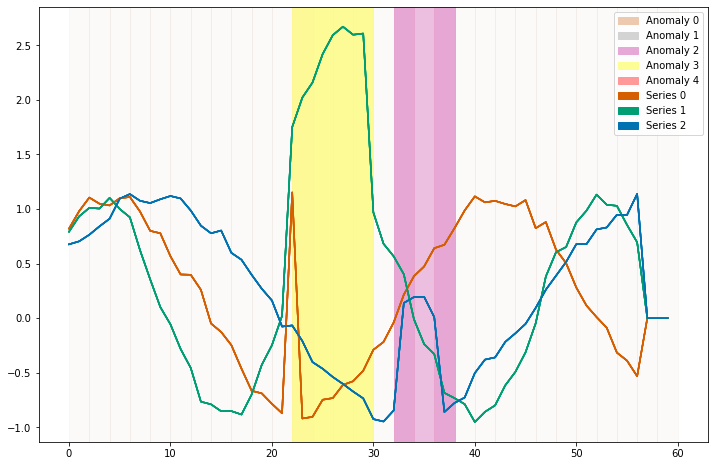

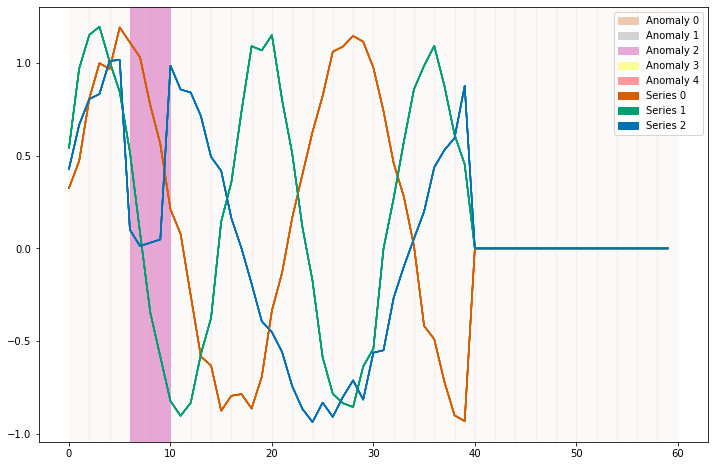

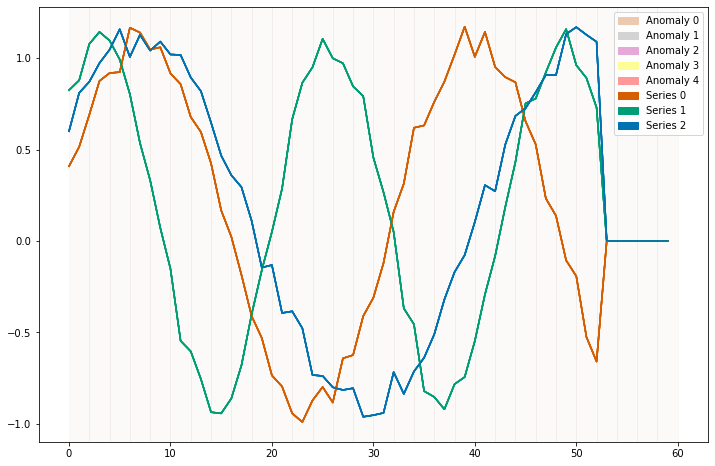

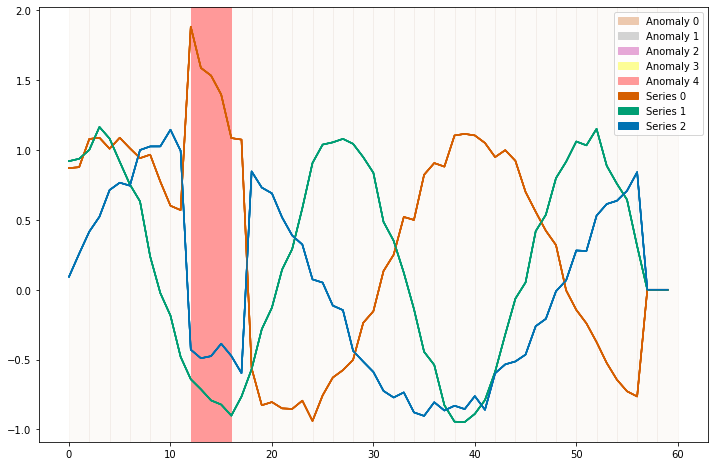

In [17]:
counter = 0
for k in np.random.randint(0, X_test.shape[0], 20):
    counter += 1
    for z in range(5):
        predicted = anomaly_detector.predict(X_test[k : k + 1])[0, ..., z]
        plt.gca().set_prop_cycle("color", series_colors)
        plt.plot(X_test[k])
        for i, q in enumerate(predicted):
            if q < 0.5:
                q = 0.01
            plt.axvspan(
                i * INTERVAL_WIDTH,
                i * INTERVAL_WIDTH + INTERVAL_WIDTH,
                color=anomaly_colors[z],
                alpha=q,
            )
    plt.legend(handles=patches)
    plt.show()
